In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])

        pop = new_pop
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid[0]), color='g', marker='*', linewidth=1, markersize=1, label="Fidelidade de estados")
    ax.plot(ts, np.abs(fid[1]), color='r', marker='8', linewidth=1, markersize=1, label="Fidelidade da porta")
    ax.plot(ts, np.abs(fid[2]), color='b', marker='.', linewidth=1, markersize=1, label="Distância entre matrizes")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    # x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    # axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    # axins.set_xlim(0.009, 0.020)
    # axins.set_ylim(0.98, 1)

    # axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    # axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    # axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    # ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    contador = 0
    r = 1
    w = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,101),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:

        if contador == 0:
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            D = np.linalg.norm(Uto-Uf)**2
            distance_vector.append(D)
            fx_vector.append(a)
            fy_vector.append(b)
            fz_vector.append(c)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            rho_vector[0][w] = pt[0][0]
            rho_vector[1][w] = pt[0][1]
            rho_vector[2][w] = pt[1][0]
            rho_vector[3][w] = pt[1][1]
            fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            t += 1
            w += 1
        else:
            #h = 0.0001
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            D = np.linalg.norm(Uto-Uf)**2
            distance_vector.append(D)
            fx_vector.append(a)
            fy_vector.append(b)
            fz_vector.append(c)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            rho_vector[0][w] = pt[0][0]
            rho_vector[1][w] = pt[0][1]
            rho_vector[2][w] = pt[1][0]
            rho_vector[3][w] = pt[1][1]
            fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            t += 1
            w += 1
        if  (1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1):
            contador = 2
            distance_vector[-1] = distance_vector[-2]
            rho_vector[0][w] = rho_vector[0][w-1]
            rho_vector[1][w] = rho_vector[1][w-1]
            rho_vector[2][w] = rho_vector[2][w-1]
            rho_vector[3][w] = rho_vector[3][w  -1]
            fid_vector[-1] = fid_vector[-2]
            fid_autores[-1] = fid_autores[-2]
        
            
        
        print(f"Distância: {distance_vector[-1]}")
        print(f"Fidelidade: {fid_vector[-1]}")
        print(f"Fidelidade da porta: {fid_autores[-1]}")
        Ut = Uto
        

    print(f"O rho gerado foi: {pt}") 
    print(f"A matriz de evolução Ut gerada foi: {Ut}")
    print(f"Portanto, a distância gerada foi: {D}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    densidade(rho_vector,w,lbda)
    fidelidade([fid_vector, fid_autores, distance_vector],t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Distância: 7.927423226541577
Fidelidade: (0.5047278204615052-9.135069184204843e-06j)
Fidelidade da porta: 0.3273947603207768
Distância: 6.908935100589284
Fidelidade: (0.5696956663950032-1.8451041390098837e-05j)
Fidelidade da porta: 0.26716471637338063
Distância: 4.985787492905042
Fidelidade: (0.6879037733638984+0.00023541826162122193j)
Fidelidade da porta: 0.2711804030642659
Distância: 2.7563658690476966
Fidelidade: (0.8271055128098601-0.00013578555256549428j)
Fidelidade da porta: 0.4685489684316546
Distância: 0.9145743811570067
Fidelidade: (0.9424305252195556-7.899891089558569e-05j)
Fidelidade da porta: 0.7876307890914104
Distância: 0.22329584262066718
Fidelidade: (0.9862542759211481+4.117368774324222e-05j)
Fidelidade da porta: 0.9471062711185633
Distância: 0.06242175309573692
Fidelidade: (0.9964372189655665+6.841643388969439e-05j)
Fidelidade da porta: 0.9867458618882204
Distância: 0.018199953123494993
Fidelidade: (0.9993128494399424-1.8491213761037564e-05j

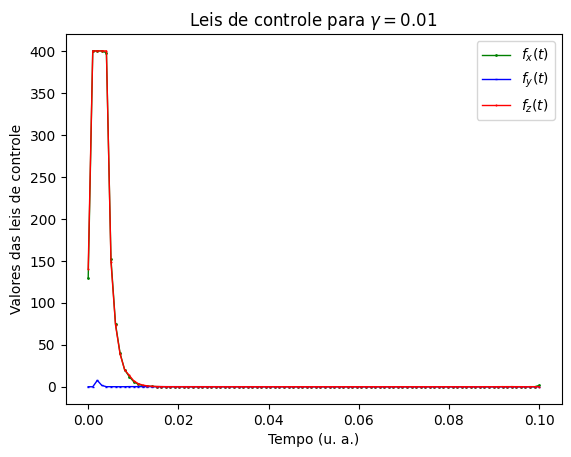

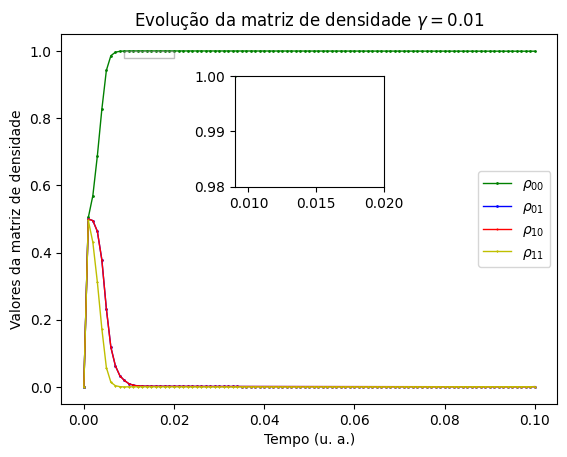

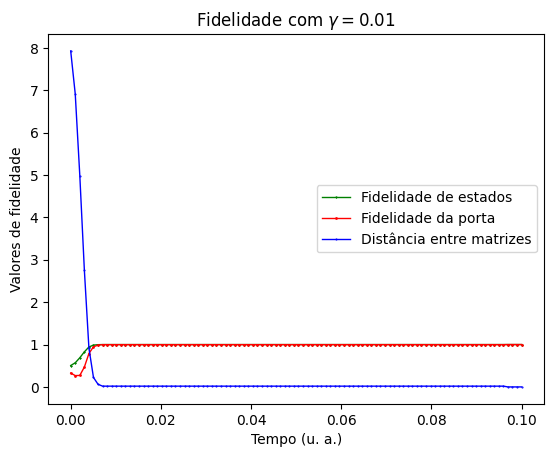

Terminou a função principal
Veja o log: (Dos estados)
[(0.50472782046150520334-9.135069184204843675e-06j), (0.5696956663950032094-1.845104139009883608e-05j), (0.6879037733638983814+0.00023541826162122192886j), (0.8271055128098601324-0.0001357855525654942802j), (0.9424305252195556019-7.899891089558569313e-05j), (0.9862542759211481611+4.1173687743242221242e-05j), (0.99643721896556644276+6.8416433889694384094e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), (0.99931284943994240483-1.8491213761037562874e-05j), 

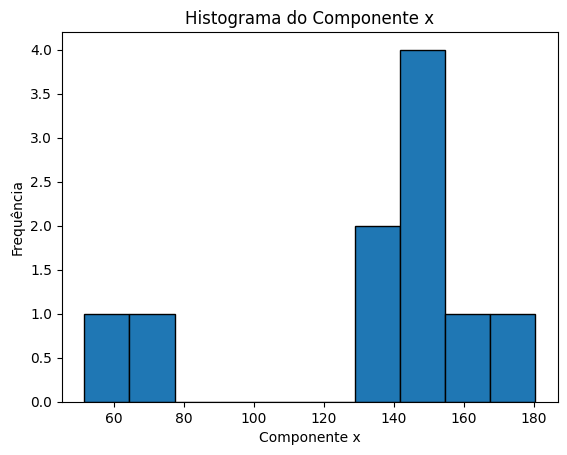

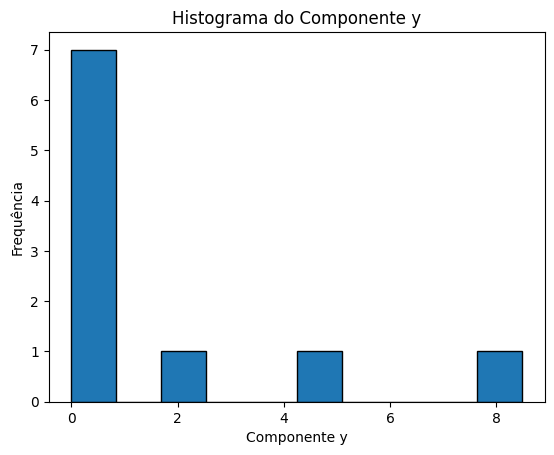

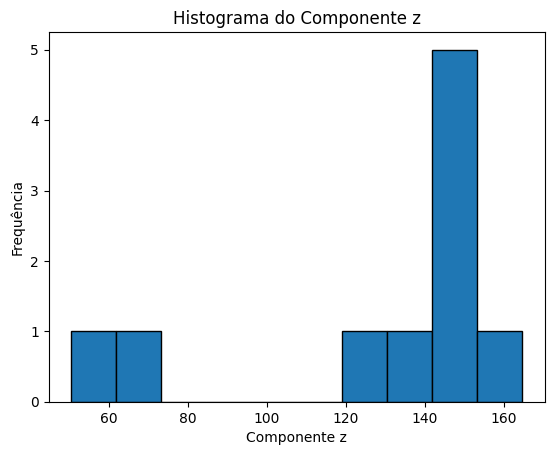

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9999315515790349
Estados: (0.9994818805348327+1.8728090539077457e-07j)
Distância: 6.946624335359114e-06
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[(0.50472782046150520334-9.135069184204843675e-06j),
 (0.5696956663950032094-1.845104139009883608e-05j),
 (0.6879037733638983814+0.00023541826162122192886j),
 (0.8271055128098601324-0.0001357855525654942802j),
 (0.9424305252195556019-7.899891089558569313e-05j),
 (0.9862542759211481611+4.1173687743242221242e-05j),
 (0.99643721896556644276+6.8416433889694384094e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761037562874e-05j),
 (0.99931284943994240483-1.8491213761

In [23]:
fid_autores

[0.3273947603207768,
 0.26716471637338063,
 0.2711804030642659,
 0.4685489684316546,
 0.7876307890914104,
 0.9471062711185633,
 0.9867458618882204,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.9977883656434908,
 0.997788365

In [24]:
rho_vector

array([[ 0.00000000e+00+0.00000000e+00j,  5.04522207e-01+0.00000000e+00j,
         5.69430593e-01+0.00000000e+00j,  6.87803559e-01+0.00000000e+00j,
         8.26969421e-01+0.00000000e+00j,  9.42348994e-01+0.00000000e+00j,
         9.86160240e-01+0.00000000e+00j,  9.96430428e-01+0.00000000e+00j,
         9.99294310e-01+0.00000000e+00j,  1.00001065e+00+0.00000000e+00j,
         1.00028010e+00+0.00000000e+00j,  1.00033634e+00+0.00000000e+00j,
         1.00034224e+00+0.00000000e+00j,  1.00033619e+00+0.00000000e+00j,
         1.00032729e+00+0.00000000e+00j,  1.00031770e+00+0.00000000e+00j,
         1.00030794e+00+0.00000000e+00j,  1.00029812e+00+0.00000000e+00j,
         1.00028829e+00+0.00000000e+00j,  1.00027844e+00+0.00000000e+00j,
         1.00026858e+00+0.00000000e+00j,  1.00025872e+00+0.00000000e+00j,
         1.00024884e+00+0.00000000e+00j,  1.00023896e+00+0.00000000e+00j,
         1.00022908e+00+0.00000000e+00j,  1.00021918e+00+0.00000000e+00j,
         1.00020928e+00+0.00000000e+00

In [25]:
distance_vector

[7.927423226541577,
 6.908935100589284,
 4.985787492905042,
 2.7563658690476966,
 0.9145743811570067,
 0.22329584262066718,
 0.06242175309573692,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.018199953123494993,
 0.

In [26]:
fx_vector

[129.3284995802154,
 400,
 400,
 400,
 397.7932859838165,
 152.31233361663067,
 74.70242569067699,
 39.85709517281981,
 20.198137445669303,
 12.156921660749568,
 5.908807433790907,
 2.8720356806254026,
 1.3947295167712552,
 0.6747033909105365,
 0.3212695350464572,
 0.14365430422263015,
 0.051254125931087774,
 0.009342007424869903,
 -0.0001475655275403609,
 -4.670657563365932e-05,
 0.0004937025495978242,
 0.000701510910027181,
 0.0007689015343417122,
 0.000793281906846674,
 0.0008055114301477734,
 0.000814475322762534,
 0.0008226736854047012,
 0.0008308110094138108,
 0.0008390916607243226,
 0.000847581433343278,
 0.0008563081708447967,
 0.0008652897876370372,
 0.0008745421187282346,
 0.0008840811722384545,
 0.0008939238354991608,
 0.0009040881609590559,
 0.0009145935465793079,
 0.000925460899428264,
 0.00093671280952691,
 0.000948373743793085,
 0.0009604702653093905,
 0.0009730312834447322,
 0.000986088339828009,
 0.0009996759370541827,
 0.0010138319175414384,
 0.0010285979023620453,
 0

In [27]:
fy_vector

[2.068703629490182e-05,
 -0.08759067889897025,
 7.566312839995439,
 1.5079313768453273,
 0.030794912735317936,
 0.03101270095946122,
 0.009964941935225497,
 0.0020931989383527814,
 -0.00025226945722483927,
 0.11746677116105582,
 0.11309950167714367,
 0.10918274399916307,
 0.10547315998138464,
 0.10190614668103916,
 0.0984626338490801,
 0.09513507399956152,
 0.09191884258297864,
 0.08881009322634571,
 0.08580525834067675,
 0.08290093774343307,
 0.08009385036085336,
 0.07738080750555322,
 0.0747587189559131,
 0.07222459891996066,
 0.06977556466999342,
 0.06740883345531028,
 0.06512171929270211,
 0.06291162984055314,
 0.06077606337406833,
 0.058712605859767446,
 0.05671892812561264,
 0.05479278312309402,
 0.05293200327769993,
 0.05113449792435905,
 0.04939825082459131,
 0.04772131776226257,
 0.046101824215039416,
 0.04453796309879859,
 0.04302799258248463,
 0.04157023397112292,
 0.04016306965493213,
 0.03880494112278782,
 0.037494347038537865,
 0.036229841379038195,
 0.03501003163310402,


In [28]:
fz_vector

[140.2951503719171,
 400,
 400,
 400,
 400,
 148.8891774115759,
 73.51980706112079,
 38.87543579038274,
 20.19219498034705,
 13.588665123313117,
 7.038309458051408,
 3.6463406248920616,
 1.8884227681085357,
 0.9765986258443763,
 0.5024222275918144,
 0.2537037389988346,
 0.12023019885859794,
 0.04730213328507388,
 0.012662274553172863,
 0.002470939438002105,
 0.0009152824417252986,
 0.0007939648521682538,
 0.0008040177262630538,
 0.0008164040173538403,
 0.0008260185422496319,
 0.0008346234168933597,
 0.0008430408102968329,
 0.0008515466092677004,
 0.0008602327704461329,
 0.0008691356916192133,
 0.0008782758511167027,
 0.0008876696539634396,
 0.0008973329813411202,
 0.0009072823028640625,
 0.0009175350825146311,
 0.0009281099870975598,
 0.0009390270480743798,
 0.0009503078221798772,
 0.0009619755665069701,
 0.0009740554349264713,
 0.0009865747003517389,
 0.0009995630081852669,
 0.0010130526659304778,
 0.001027078975862357,
 0.0010416806182393032,
 0.0010569000948877708,
 0.00107278424461

In [29]:
a

[(129.3284995802154, 2.068703629490182e-05, 140.2951503719171),
 (146.08738149607683, 3.0888331301628913e-06, 145.6840334049702),
 (51.56007569360161, 4.8051055211888505, 50.47181219101104),
 (71.96831007953251, 1.7746260785655281, 67.13633036732274),
 (153.71806863720315, 0.059229625023170425, 152.87910195631656),
 (151.76893048586646, 0.0, 150.53773230180104),
 (152.82917396345806, 2.995454792570428e-05, 151.75085530050006),
 (158.93306923366768, 0.006291864920391349, 145.6704178846453),
 (136.51326708198297, 0.0, 121.02636217473372),
 (180.32183969730008, 8.482008193405498, 164.69902408923198)]